````
AESM1450 - Geophysical Prospecting  -- Controlled-Source ElectroMagnetic (CSEM) Modelling
````
# 4. 3D Modelling

In this tutorial we start with a 1D model and compute it with a 1D modeller and a 3D modeller. We then start to reduce the extent of the target layer successively, moving from a 1D model to a 2D model, and observe when the 1D results start to fail predicting the responses.

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

### Define Model

- We assume a deep sea model, so we completely ignore the air.
- Water resistivity of 0.3 Ohm.m, background has 1 Ohm.m.
- 100 m target layer of 100 Ohm.m at 2 km below the seafloor.

In [3]:
# Depth model
depth = [-2000, -4000, -4100]

# Corresponding resistivity models
res_bg = [0.3, 1, 1, 1]      # Background model
res_tg = [0.3, 1, 100, 1]   # Resistive model

### Define Survey

- Source at the origin, receivers up to 10 km.
- All inline Exx.
- We use 3 distinct frequencies.

Note that we now use `empymod.bipole` instead of `empymod.dipole`. In this way the source and receiver input are the same for `empymod` and `emg3d`. The important difference is: Instead of an `ab`-configuration as before we have to provide azimuth and dip information. So `ab=11`, hence $E_{xx}$, corresponds to azimuth $\theta=0$ and dip $\varphi=0$.

In [4]:
# Source and receivers
# [x, y, z, azimuth, dip]
src = [0, 0, -1950, 0, 0]
off = np.arange(5, 101)*100
rec = [off, off*0, -2000, 0, 0]

# Frequencies
freq = np.array([0.1, 0.5, 1])

### Calculate 1D responses and plot them

In [5]:
resp_bg = empymod.bipole(src, rec, depth, res_bg, freq)
resp_tg = empymod.bipole(src, rec, depth, res_tg, freq)


:: empymod END; runtime = 0:00:00.187309 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.081814 :: 1 kernel call(s)



<IPython.core.display.Javascript object>


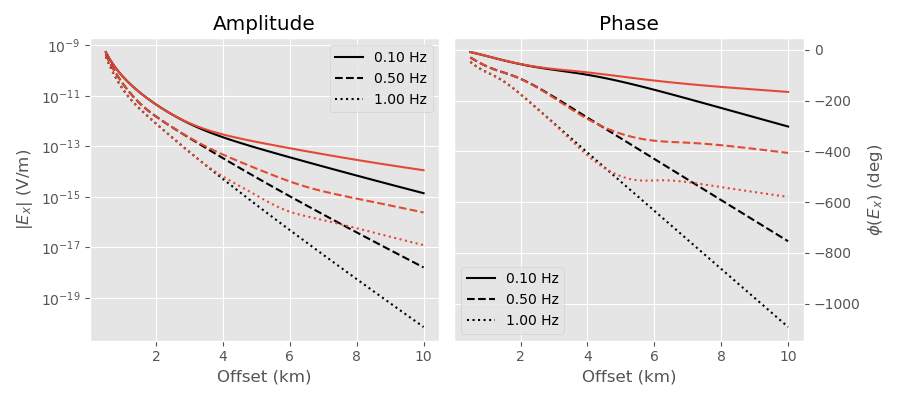

In [6]:
plt.figure(figsize=(9, 4))

ls = ['-', '--', ':']

ax1 = plt.subplot(121)
plt.title('Amplitude')
for i, f in enumerate(freq):
    plt.plot(off/1e3, resp_bg[i, :].amp, 'k', ls=ls[i], label=f"{f:.2f} Hz")
    plt.plot(off/1e3, resp_tg[i, :].amp, 'C0', ls=ls[i])
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('$|E_x|$ (V/m)')
plt.yscale('log')

ax2 = plt.subplot(122)
plt.title('Phase')
for i, f in enumerate(freq):
    plt.plot(off/1e3, resp_bg[i, :].pha, 'k', ls=ls[i], label=f"{f:.2f} Hz")
    plt.plot(off/1e3, resp_tg[i, :].pha, 'C0', ls=ls[i])
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('$\phi(E_x)$ (deg)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.tight_layout()
plt.show()

# Introduction to `emg3d`

`emg3d` is a 3D modeller, and 3D modellers are complex things. There are many parameters that play a crucial role in them:
- Computational mesh extend (big enough to avoid boundary effects).
- Mesh: Cells must be small enough to yield accurate results, yet as big as possible to reduce runtime and memory usage.
- How to put your model onto the mesh, how to retrieve your responses.

In this initial example we provide you with all the required inputs, and you should only have to adjust
- the frequency (0.1, 0.5, 1 Hz), and
- the lateral extent in x-direction of the target zone.

For lots of examples have a look at the gallery: https://empymod.github.io/emg3d-gallery


## Create a mesh

The mesh we create has at its core cells of 100x100x100 m, where core means:
- x: -100, 0, 100, ..., 9900, 10000, 10100 (edge locations)
- x: -50, 50, 150, ..., 9850, 9950, 10050 (centre locations)
- y: -100, 0, 100 (edge locations)
- z: -4100, -4000, ..., -2000, -1900 (edge locations)

The $E_x$-field is located at the x-centre, but on the y- and z-nodes. So this discretization ensures that our sources and receivers are exactly at these locations. This is not a requirement, but it yields the most precise results. However, the three-dimensional cubic spline included in `emg3d` does a pretty good job at interpolating if your source and receivers are not exactly at these locations.

Outside of this core-domain we increase the cell-size by a factor 1.5 with each cell, to quickly get to large distances.

In [7]:
cs = 100        # Base cell size
nx = 10200/cs   # Center points from 0 to 10 km
ny = 2          # 2D, so we start stretching straight away
nz = 2150/cs    # Regular up to target plus one in the other dir. 
npadx = 12
npady = 14
npadz = 10
alpha = 1.5    # Stretching outside

gridinput = {
    'freq': 0.5,            # The frequency we are looking at
    'min_width': 100,
    'max_domain': 50000,
    'verb': 0,
}

xx, x0 = emg3d.utils.get_hx_h0(
    res=[res_tg[0], res_tg[2]], fixed=src[0], domain=[-50, 10050], **gridinput)
yy, y0 = emg3d.utils.get_hx_h0(
    res=[res_tg[0], res_tg[2]], fixed=src[1]-100, domain=[-100, 100], **gridinput)
zz, z0 = emg3d.utils.get_hx_h0(
    res=[res_tg[0], res_tg[1], res_tg[0]], fixed=rec[2], domain=[-4100, -1900], **gridinput)

mesh = discretize.TensorMesh([xx, yy, zz], x0=np.array([x0, y0, z0]))
mesh

TensorMesh: 163,840 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128    -46,597.90     56,597.90    100.00 14,966.68    1.47
   y     32    -45,684.10     64,829.42    100.00 19,245.32    1.42
   z     40     -8,256.61        580.23    100.00    931.32    1.25

To look at cell centers and cell edges use the following commands:

    mesh.vectorCCx  # Cell centers in x-direction
    mesh.vectorNx   # Cell nodes in x-direction
    
and the same for `y` and `z`.

## Put the resistivity model on the mesh

We write a little function here that we can reuse then to adjust our model.

<IPython.core.display.Javascript object>


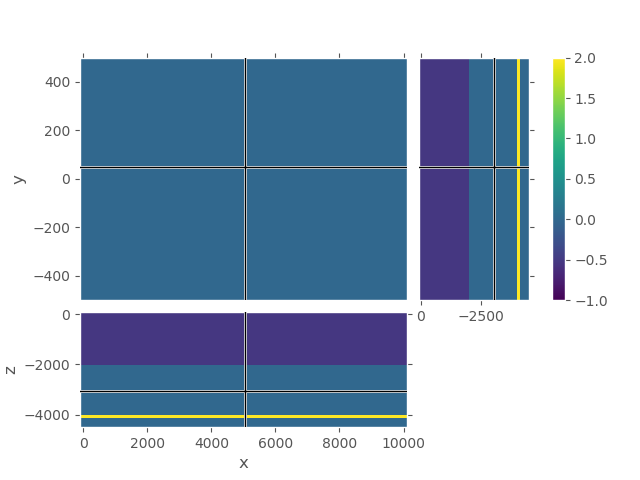

In [8]:
def create_model(xmin, xmax, plot=False):

    # Initiate with the resistivity of water
    res = np.ones(mesh.nC)*res_tg[0]

    # Put the background resistivity to all cells below depth[0]
    res[mesh.gridCC[:, 2] < depth[0]] = res_tg[1]

    # Include the target
    target_inds = (
        (mesh.gridCC[:, 0] > xmin) & (mesh.gridCC[:, 0] < xmax) &  # Indices based on x-coordinate
        (mesh.gridCC[:, 2] < depth[1]) & (mesh.gridCC[:, 2] > depth[2])  # AND depth
    )
    res[target_inds] = res_tg[2]

    # Create a emg3d-Model instance
    model = emg3d.utils.Model(mesh, res)

    # QC our model
    if plot:
        mesh.plot_3d_slicer(
            np.log10(model.res_x), clim=[-1, 2],
            xlim=[-100, 10100], ylim=[-500, 500], zlim=[-4500, 100],
        )
    
    return model

# Get the 1D model
model = create_model(-np.inf, np.inf, plot=True)

## Create the source field

In [9]:
fi = 1  # Current frequency index
sfield = emg3d.utils.get_source_field(mesh, src, freq[fi])
print(f"Current frequency: {freq[fi]} Hz")

Current frequency: 0.5 Hz


## Calculate the field

In [10]:
solve_inp = {
    'grid': mesh,
    'sfield': sfield,
    'sslsolver': True,
    'semicoarsening': True,
    'linerelaxation': True,
}
efield = emg3d.solve(model=model, verb=-1, **solve_inp)

:: emg3d :: 7.2e-07; 2(10); 0:00:30; CONVERGED


## Obtain the responses at the receiver

In [11]:
egd_resp = emg3d.utils.get_receiver(mesh, efield.fx, (rec[0], rec[1], rec[2]))

## Plot it

<IPython.core.display.Javascript object>


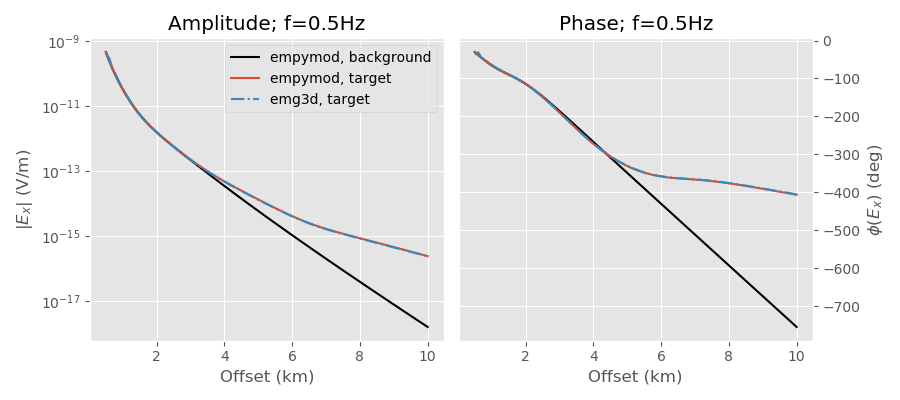

In [12]:
def plot_it(fi, resp):
    """Define a plot-function to re-use."""
    plt.figure(figsize=(9, 4))

    ax1 = plt.subplot(121)
    plt.title(f"Amplitude; f={freq[fi]}Hz")
    plt.plot(off/1e3, resp_bg[fi, :].amp, 'k', label=f"empymod, background")
    plt.plot(off/1e3, resp_tg[fi, :].amp, 'C0-', label="empymod, target")
    plt.plot(off/1e3, resp.amp, 'C1-.', label='emg3d, target')
    plt.legend()
    plt.xlabel('Offset (km)')
    plt.ylabel('$|E_x|$ (V/m)')
    plt.yscale('log')

    ax2 = plt.subplot(122)
    plt.title(f"Phase; f={freq[fi]}Hz")
    plt.plot(off/1e3, resp_bg[fi, :].pha, 'k')
    plt.plot(off/1e3, resp_tg[fi, :].pha, 'C0-')
    plt.plot(off/1e3, resp.pha, 'C1-.')
    plt.xlabel('Offset (km)')
    plt.ylabel('$\phi(E_x)$ (deg)')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    plt.tight_layout()
    plt.show()

plot_it(fi, egd_resp)

## Adjusting the model

Now everything is in place, and we can simply start adjusting the `model` by keeping the `mesh` and the `sfield` the same.

<IPython.core.display.Javascript object>


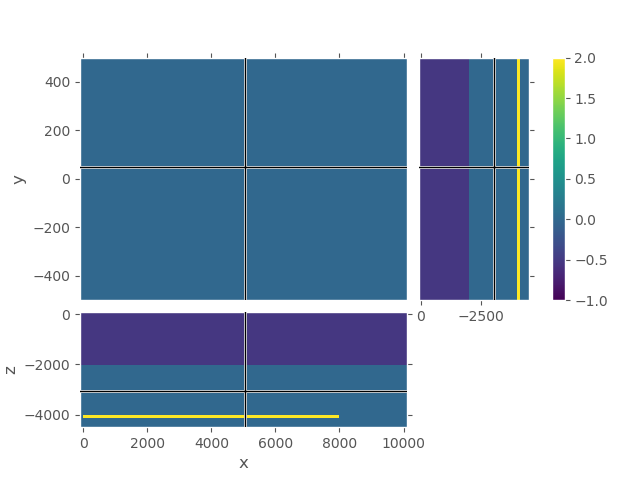

In [13]:
# Adjust the x-extent of the target
model = create_model(xmin=0, xmax=8000, plot=True)

In [14]:
# Re-calculate
efield = emg3d.solve(model=model, verb=-1, **solve_inp)
egd_resp = emg3d.utils.get_receiver(mesh, efield.fx, (rec[0], rec[1], rec[2]))

:: emg3d :: 8.4e-07; 2(10); 0:00:28; CONVERGED


<IPython.core.display.Javascript object>


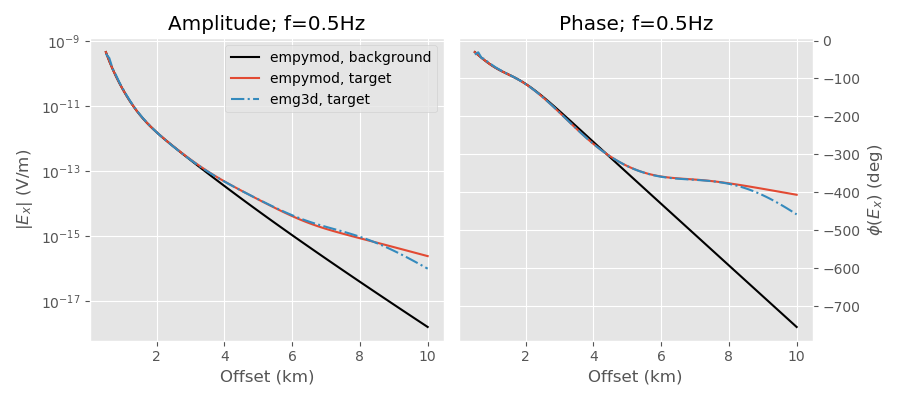

In [15]:
# Plot it
plot_it(fi, egd_resp)

# Task

- Move the x-dimension of the target and see its effect.
- Observe that at offsets where the receivers are no longer over the target the amplitude curve becomes parallel to the background amplitude curve.
- What can you say about the phase behaviour for those offsets?
- Try to figure out when the 1D assumption breaks down and you have to calculate 3D models. Can you come up with a rule of thumb?
- Does your rule of thumb also work for the other two frequencies? Or do you have to include frequency as a parameter into your rule of thumb?

# Further tasks

- If you are fast you can also try to adjust the notebook to include an analysis of the target-width in y-direction. In this case you have to carefully adjust the `mesh`-creation for the y-direction as well.
- Even further you could investigate the importance of target thickness or target depth. Again, carefully when meshing, this time in z-direction.

In [16]:
empymod.Report([emg3d, discretize])

--------------------------------------------------------------------------------
  Date: Wed Feb 26 09:44:31 2020 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 (default, Jan  8 2020, 19:59:22)  [GCC 7.3.0]

             emg3d : 0.9.3
        discretize : 0.4.11
             numpy : 1.18.1
             scipy : 1.4.1
             numba : 0.48.0
           empymod : 1.10.6.dev5+gfc91021
           IPython : 7.12.0
        matplotlib : 3.1.3

  Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------